# **Notebook for Deep Kalman Filter**

## **Setup Google Colab (for GPU power)**

To use cuda, the following lines initiate Google Colab. The user should change the file localtion.

In [1]:
!pip install pyro-ppl

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Insert directory 
os.chdir('...') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import data and preprocessing**

In [3]:
import logging
import pickle
import torch
import torch.utils as tutils
import time as time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.backends.backend_pdf
import math
import pandas as pd
from pathlib import Path
from random import sample
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from dkf import DKF, reversed_input

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO

In [4]:
# Load data
data = pd.read_csv('data_clean.csv', sep = ',')
data = data[['Start tidspunkt', 'Latitude (Start)', 'Longitude (Start)']]
weekday = np.zeros(len(data['Start tidspunkt']))
dayhour = np.zeros(len(data['Start tidspunkt']))

for i in range(len(data['Start tidspunkt'])):
    weekday[i] = time.strftime('%w', time.gmtime(data['Start tidspunkt'][i]))
    dayhour[i] = time.strftime('%H', time.gmtime(data['Start tidspunkt'][i]))

# Return weekly data 
data['Weekhour'] = weekday*24 + dayhour
data_tensor = torch.tensor(data.values, dtype=torch.float)
randin = torch.randint(len(data_tensor), (data_tensor.size(0),))

# Scale input data 
x = data_tensor[randin, 1:3]
x = preprocessing.scale(x)
x = torch.tensor(x, dtype=torch.float)

# Return indices 
H = data_tensor[randin, 3]
H = H.unsqueeze(-1)

In [5]:
T = 7*24

# Set dimensions 
nx, ny = 64, 64
U_array = np.zeros((T, nx, ny))

lat_bins = np.linspace(x[:,0].min(), x[:,0].max(), nx+1)
lon_bins = np.linspace(x[:,1].min(), x[:,1].max(), ny+1)

# Create 2D spatial representation     
for i in range(T):
    idx = np.argwhere(np.asarray(H == i))[:,0]
    density, _, _ = np.histogram2d(x[idx,1].detach().numpy(),
                                   x[idx,0].detach().numpy(),
                                   [lon_bins,lat_bins]) 
    U_array[i] = density

Split the data into a training and a validation part. 7:3 split is used.

In [6]:
def train_val_split(data, ratio, T):
    """
    Split observation data into training part and validation part
    """

    length = data.shape[0] - ((T - 1) * 2)
    train_length = int(length * ratio)
    split_point = train_length + T
    valid_length = length - train_length

    # Split up training data
    train_start = 0
    train_end = train_start + train_length
    train_data = [data[i:i + T]
                  for i in range(train_start, train_end)]

    # Split up validation data
    valid_start = train_end + T - 1
    valid_end = valid_start + valid_length
    valid_data = [data[i:i + T]
                  for i in range(valid_start, valid_end)]

    train_data = np.stack(train_data)
    valid_data = np.stack(valid_data)

    return train_data, valid_data

In [7]:
train_dataset, valid_dataset = train_val_split(U_array, 0.7, 30)
train_dataset = train_dataset.astype(np.float32)
valid_dataset = valid_dataset.astype(np.float32)

Functions to normalize and retransform the data. 
Normalization is between -1 and 1, which works well with the tanh-function

In [8]:
def normalize(data):
    data_min = 0
    data_max = 100
    return (2.0 * (data - data_min) / (data_max - data_min)) - 1

def retransform(data):
    data_min = 0
    data_max = 100
    return ((data * (data_max - data_min)) + data_max + data_min) / 2.0

## **Training, validation and forecasting**

In [9]:
# Constants
T = 30
obs_length = 20
pred_length = T - obs_length
train_batch_size = 16
valid_batch_size = 1

# Model parameters 
input_channels = 1
z_channels = 50
emission_channels = [64, 32]
transition_channels = 64
flatten_channels = [32, 64]
rnn_input_dim = 256
rnn_channels = 128
kernel_size = 3
num_iafs = 0
iaf_dim = 50

# Cuda device 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Create data loaders from data
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, 
                              shuffle=True, num_workers=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, 
                              num_workers=4)

In [10]:
# Training parameters
width = nx
height = ny
input_dim = width * height

# Call Deep Kalman Filter 
dkf = DKF(input_channels=input_channels, 
          z_channels=z_channels, 
          emission_channels=emission_channels,
          transition_channels=transition_channels, 
          flatten_channels=flatten_channels, 
          rnn_input_dim=rnn_input_dim, 
          rnn_channels=rnn_channels, 
          kernel_size=kernel_size, 
          height=height, width=width,  
          num_layers=1, rnn_dropout_rate=0.1,
          num_iafs=num_iafs, iaf_dim=iaf_dim, use_cuda=use_cuda)

# Initialize model
epochs = 300
learning_rate = 0.0003
beta1 = 0.99
beta2 = 0.9996
clip_norm = 10.0
lr_decay = 0.9999
weight_decay = 1.0

# Optimization 
adam_params = {"lr": learning_rate, "betas": (beta1, beta2),
               "clip_norm": clip_norm, "lrd": lr_decay,
               "weight_decay": weight_decay}
adam = ClippedAdam(adam_params)
elbo = Trace_ELBO()
svi = SVI(dkf.model, dkf.guide, adam, loss=elbo)

In [11]:
# Training for 299 epochs, before one last validation and forecast 
logging.info("Training model")

# Some annealing parameters 
ann_epochs = 1000
N_train_size = 3000
latent_samples = 1000
min_ann_factor = 0.2
ann_epochs = 1000
mini_batches = int(3000 / train_batch_size +
                      int(3000 % train_batch_size > 0))

# Losses 
squared_error = []
train_loss = []

for epoch in tqdm(range(epochs), desc='Epoch', leave=True):
    running_loss_train = 0
    dkf.train(True)
    idx = 0
    for mini_batch_t, data in enumerate(tqdm(train_dataloader, desc='Train', leave=True)):
        if ann_epochs > 0 and epoch < ann_epochs:
            # Anealing factor for the current mini-batch
            min_af = min_ann_factor
            ann_factor = min_af + (1.0 - min_af) * \
                (float(mini_batch_t + epoch * mini_batches + 1) /
                  float(ann_epochs * mini_batches))
        else:
            ann_factor = 1.0

        # Normalize data 
        data = normalize(data.unsqueeze(2).to(device))
        batch_size, length, _, w, h = data.shape

        # Reverse data for RNN 
        data_reversed = reversed_input(data)
        
        # Gradient step
        loss = svi.step(data, data_reversed, ann_factor)

        # Running losses
        running_loss_train += loss
        idx += 1

    # Average losses
    loss_avg = running_loss_train / (len(train_dataset) * T)
    train_loss.append(loss_avg)
    logging.info("Epoch: %d, Training loss: %1.5f",
                  epoch, loss_avg)

    # # Time to time evaluation
    if epoch == epochs - 1:
        running_loss_valid = 0
        dkf.train(False)

        # Choose N_latents > 1 for averaging the predictions 
        N_latents = 1 
        with torch.no_grad():
            for i, data in enumerate(tqdm(valid_dataloader, desc='Eval', leave=True)):
                # Normalize and reverse 
                data = normalize(data.unsqueeze(2).to(device))
                batch_size, length, _, w, h = data.shape
                data_reversed = reversed_input(data)

                # Extract data before prediction 
                pred_data = data[:, :obs_length, :, :, :]
                pred_data_reversed = reversed_input(pred_data).cuda()
                real_data = data[:, obs_length:, :, :, :]

                # Evaluate ELBO
                val_nll = svi.evaluate_loss(data, data_reversed)

                bsize, input_seq_len, input_channels, width, height = pred_data.shape
                
                # Initiate tensors 
                pred = torch.Tensor(N_latents,
                                    bsize, 
                                    pred_length, 
                                    input_channels, 
                                    width, 
                                    height).to(pred_data.device)

                pred_loc = torch.Tensor(N_latents, 
                                        bsize, 
                                        pred_length, 
                                        input_channels, 
                                        width, 
                                        height).to(pred_data.device)
    
                pred_scale = torch.Tensor(N_latents, 
                                          bsize, 
                                          pred_length, 
                                          input_channels, 
                                          width, 
                                          height).to(pred_data.device)

                for j in range(N_latents):
                    # Use guide to find z from the inference model 
                    z_prev = dkf.guide(pred_data, pred_data_reversed)

                    for t in range(pred_length):
                        # Sample z 
                        z_pred_loc, z_pred_scale = dkf.trans(z_prev)
                        z_t = pyro.sample("z_pred_%d" % (obs_length + t), dist.Normal(z_pred_loc, z_pred_scale).to_event(1))
                        
                        # Sample y 
                        emission_loc_t, emission_scale_t = dkf.emitter(z_t)
                        y_t = pyro.sample("x_pred_%d" % (obs_length + t), dist.Normal(emission_loc_t, emission_scale_t).to_event(1))

                        # Insert into tensors
                        pred[j, :, t, :, :, :] = y_t
                        pred_loc[j, :, t, :, :, :] = emission_loc_t
                        pred_scale[j, :, t, :, :, :] = emission_scale_t
                        
                        # Update time step 
                        z_prev = z_t

                # MSE 
                loss_pred = torch.sum(
                    (pred.mean(axis=0) - real_data) ** 2
                ).detach().cpu().numpy()
                
                squared_error.append(loss_pred)
                
                # Denormalize 
                real_data = retransform(
                    data.squeeze().cpu().detach()
                )
                
                # Append the predictions 
                pred_avg = pred.mean(axis=0)
                pred_avg = pred_avg.clip(min=-1.0)
                add_pred = retransform( 
                    torch.cat(
                        [data[:, :-pred_length, :, :, :].squeeze(),
                        pred_avg.squeeze()], dim=0
                    ).cpu().detach()
                )

                # Running losses
                running_loss_valid += val_nll

                # Average losses
                valid_loss = running_loss_valid / \
                    (len(valid_dataset) * T)
                logging.info("Validation loss: %1.5f", valid_loss)

Train: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

Epoch: 100%|██████████| 300/300 [08:41<00:00,  1.74s/it]


Show predictions. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


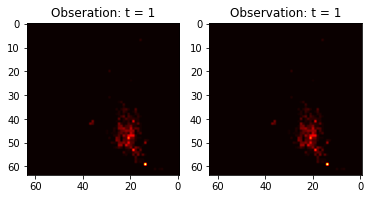

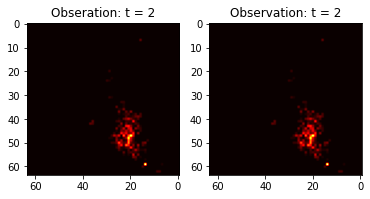

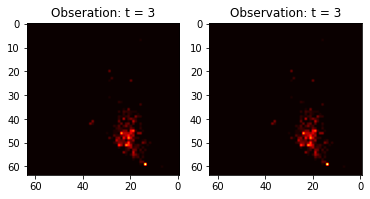

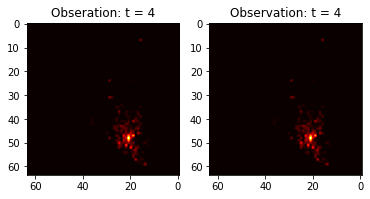

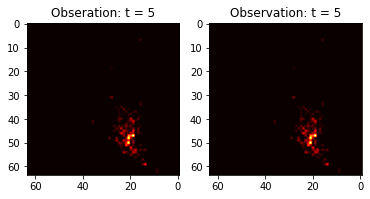

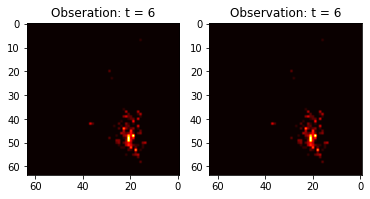

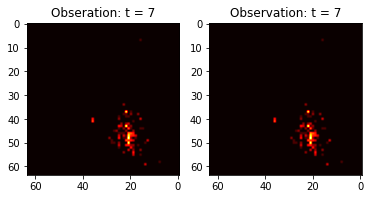

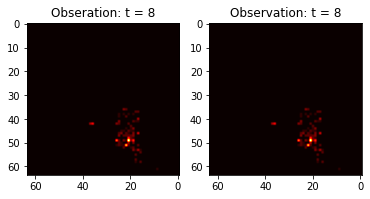

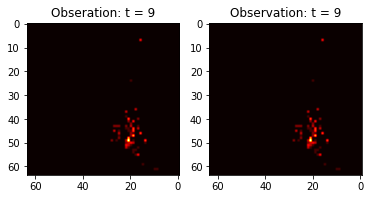

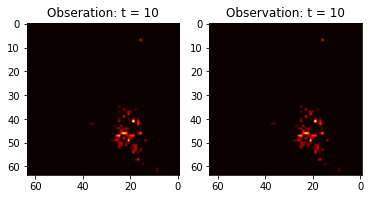

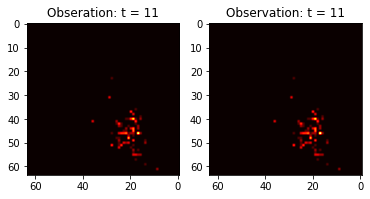

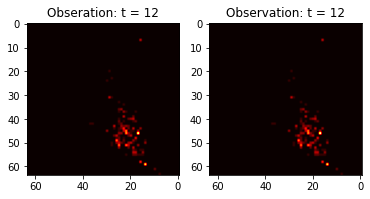

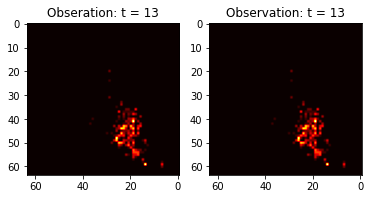

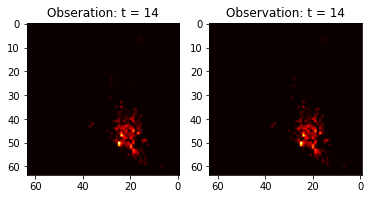

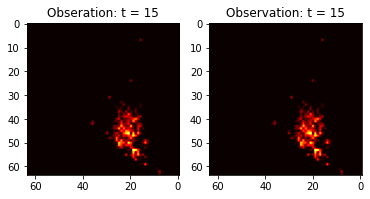

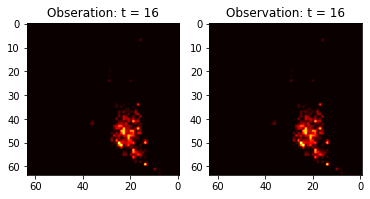

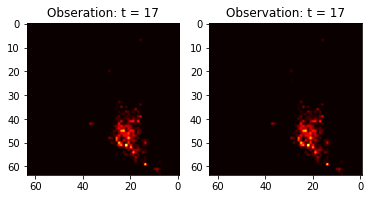

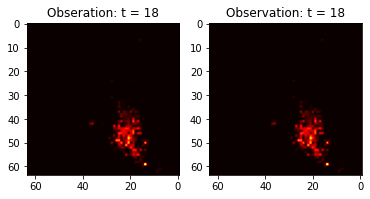

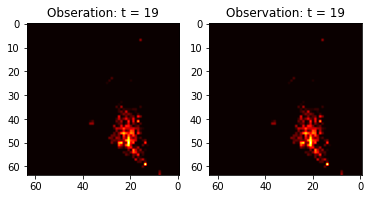

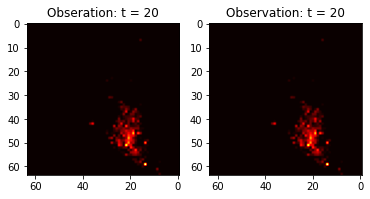

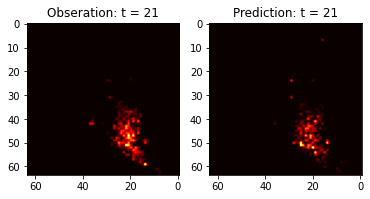

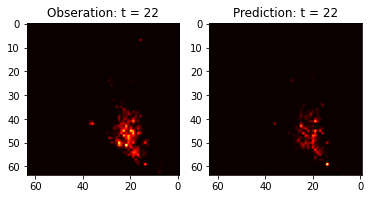

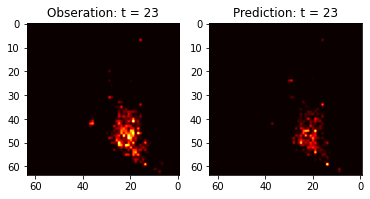

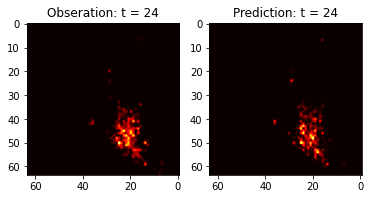

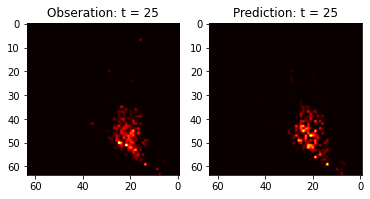

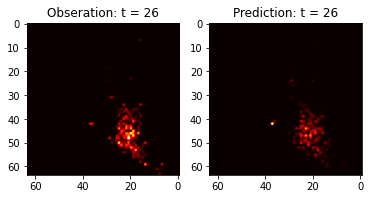

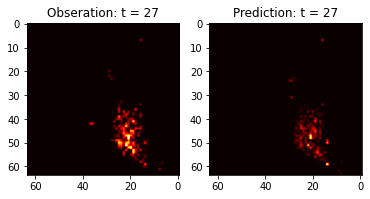

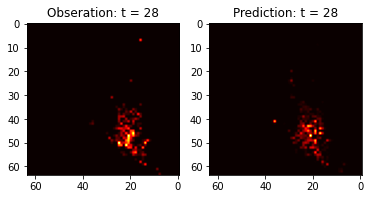

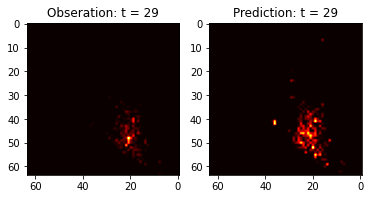

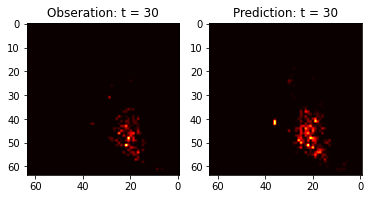

In [12]:
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
figs = []

for i in range(30): 
  fig, (ax1, ax2) = plt.subplots(1, 2)
  heat1 = ax1.imshow(real_data[i,:,:], cmap='hot')
  heat1.axes.invert_xaxis() 
  ax1.set_title('Obseration: t = %d' % (i+1))
  heat2 = ax2.imshow(add_pred[i,:,:], cmap='hot')
  heat2.axes.invert_xaxis()
  if i < 20:
    ax2.set_title('Observation: t = %d' % (i+1))
  else:
    ax2.set_title('Prediction: t = %d' % (i+1))
  figs.append(fig)

for fig in figs: # loop over all figures
    pdf.savefig(fig) # save each figure in the pdf
pdf.close()


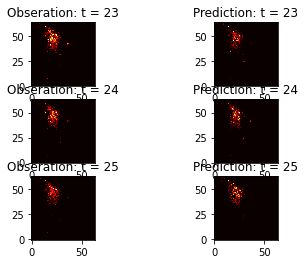

In [13]:
pdf = matplotlib.backends.backend_pdf.PdfPages("output_choosen.pdf")
fidx = [22,23,24]

fig, ax = plt.subplots(len(fidx), 2)

for idx, i in zip(fidx, range(len(fidx))): 
  heat1 = ax[i][0].imshow(real_data[idx,:,:], cmap='hot', )
  heat1.axes.invert_yaxis() 
  ax[i][0].set_title('Obseration: t = %d' % (idx+1))
  heat2 = ax[i][1].imshow(add_pred[idx,:,:], cmap='hot',aspect="equal")
  heat2.axes.invert_yaxis()
  if idx < 20:
    ax[i][1].set_title('Observation: t = %d' % (idx+1))
  else:
    ax[i][1].set_title('Prediction: t = %d' % (idx+1))

pdf.savefig(fig) # save each figure in the pdf
pdf.close()

